## Setup

In [1]:
# import statements
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# function because some of the simulations have a messed-up calendar
def preprocess(ds_in: xr.Dataset) -> xr.Dataset:
    ds_in.XTIME.attrs["units"] = "minutes since 2021-09-01 23:00:00"
    ds_in.XTIME.attrs["description"] = "minutes since 2021-09-01 23:00:00"
    return(ds_in)

def load(var: str, init_time: str, ens_num: int):
    path = "/mnt/drive2/wof-runs/"+init_time+"/"+var+"/wrfwof*.{:02d}".format(ens_num)
    return(xr.open_mfdataset(path,preprocess=preprocess,
                          decode_times=False,combine="nested",
                          concat_dim="Time")
    )
def fix_xtime(ds_in: xr.Dataset,init_time: str) -> xr.Dataset:
    if init_time in ["20", "21", "22", "23"]:
        start_date = "2021-09-01"
    elif init_time in ["00", "01", "02"]:
        start_date = "2021-09-02"
    else:
        raise ValueError("Unexpected init_time provided.")
    ds_in.XTIME.attrs["units"] = "minutes since "+start_date+" "+init_time+":00:00"
    ds_in.XTIME.attrs["description"] = ("minutes since "+start_date+" "+
                                        init_time+":00:00")
    return(xr.decode_cf(ds_in))

## Read in WoFS simulations

In [3]:
rainnc_20Z = xr.concat([fix_xtime(load("RAINNC","20Z",e),"20") for e in range(1,19)],
                       "ens")
rainnc_21Z = xr.concat([fix_xtime(load("RAINNC","21Z",e),"21") for e in range(1,19)],
                       "ens")
rainnc_22Z = xr.concat([fix_xtime(load("RAINNC","22Z",e),"22") for e in range(1,19)],
                       "ens")
rainnc_23Z = xr.concat([fix_xtime(load("RAINNC","23Z",e),"23") for e in range(1,19)],
                       "ens")
rainnc_00Z = xr.concat([fix_xtime(load("RAINNC","00Z",e),"00") for e in range(1,19)],
                       "ens")
rainnc_01Z = xr.concat([fix_xtime(load("RAINNC","01Z",e),"01") for e in range(1,19)],
                       "ens")

In [58]:
# mslp_20Z = xr.concat([fix_xtime(load("MSLP","20Z",e),"20") for e in range(1,19)],
#                        "ens")
mslp_21Z = xr.concat([fix_xtime(load("MSLP","21Z",e),"21") for e in range(1,19)],
                       "ens")
mslp_22Z = xr.concat([fix_xtime(load("MSLP","22Z",e),"22") for e in range(1,19)],
                       "ens")
mslp_23Z = xr.concat([fix_xtime(load("MSLP","23Z",e),"23") for e in range(1,19)],
                       "ens")
mslp_00Z = xr.concat([fix_xtime(load("MSLP","00Z",e),"00") for e in range(1,19)],
                       "ens")
# mslp_01Z = xr.concat([fix_xtime(load("MSLP","01Z",e),"01") for e in range(1,19)],
#                        "ens")

OSError: no files to open

## Find the point closest to Central Park

In [23]:
# Set desired latitude and longitude
nyc_lat,nyc_lon = 40.7826,-73.9656

# Isolate XLAT and XLONG for ease of use
xlat = rainnc_20Z.XLAT.isel(Time=0).squeeze().drop_vars('XTIME')
xlong = rainnc_20Z.XLONG.isel(Time=0).squeeze().drop_vars('XTIME')

# Calculate the Euclidean distance between XLAT and XLONG values and the desired point
distance = np.sqrt((xlat-nyc_lat)**2 + (xlong-nyc_lon)**2)

# Find where the distance is minimized
nyc_inds = distance.argmin(dim=["south_north","west_east"])
sn_ind, we_ind = int(nyc_inds["south_north"]),int(nyc_inds["west_east"])

## Calculate 1-hour accumulated rainfall for 1-2Z

In [4]:
def get_NYC_1Z_to_2Z(ds_in: xr.Dataset, lat_index: xr.DataArray,
                      lon_index: xr.DataArray):
    hour = ds_in.isel(Time=abs(ds_in.XTIME - np.datetime64(
        pd.to_datetime("2021-09-02 02:00:00"))).argmin()) - ds_in.isel(Time=abs(
            ds_in.XTIME - np.datetime64(
                pd.to_datetime("2021-09-02 01:00:00"))).argmin())
    return(hour.isel(south_north = lat_index,west_east = lon_index))

def get_1Z_to_2Z(ds_in: xr.Dataset):
    return(ds_in.isel(Time=abs(ds_in.XTIME - np.datetime64(
        pd.to_datetime("2021-09-02 02:00:00"))).argmin()) - ds_in.isel(Time=abs(
            ds_in.XTIME - np.datetime64(
                pd.to_datetime("2021-09-02 01:00:00"))).argmin()))

In [15]:
rainy_hour_20Z = get_NYC_1Z_to_2Z(
    rainnc_20Z,nyc_inds["south_north"],nyc_inds["west_east"]
    ).RAINNC

rainy_hour_21Z = get_NYC_1Z_to_2Z(
    rainnc_21Z,nyc_inds["south_north"],nyc_inds["west_east"]
    ).RAINNC

rainy_hour_22Z = get_NYC_1Z_to_2Z(
    rainnc_22Z,nyc_inds["south_north"],nyc_inds["west_east"]
    ).RAINNC

rainy_hour_23Z = get_NYC_1Z_to_2Z(
    rainnc_23Z,nyc_inds["south_north"],nyc_inds["west_east"]
    ).RAINNC

rainy_hour_00Z = get_NYC_1Z_to_2Z(
    rainnc_00Z,nyc_inds["south_north"],nyc_inds["west_east"]
    ).RAINNC

rainy_hour_01Z = get_NYC_1Z_to_2Z(
    rainnc_01Z,nyc_inds["south_north"],nyc_inds["west_east"]
    ).RAINNC

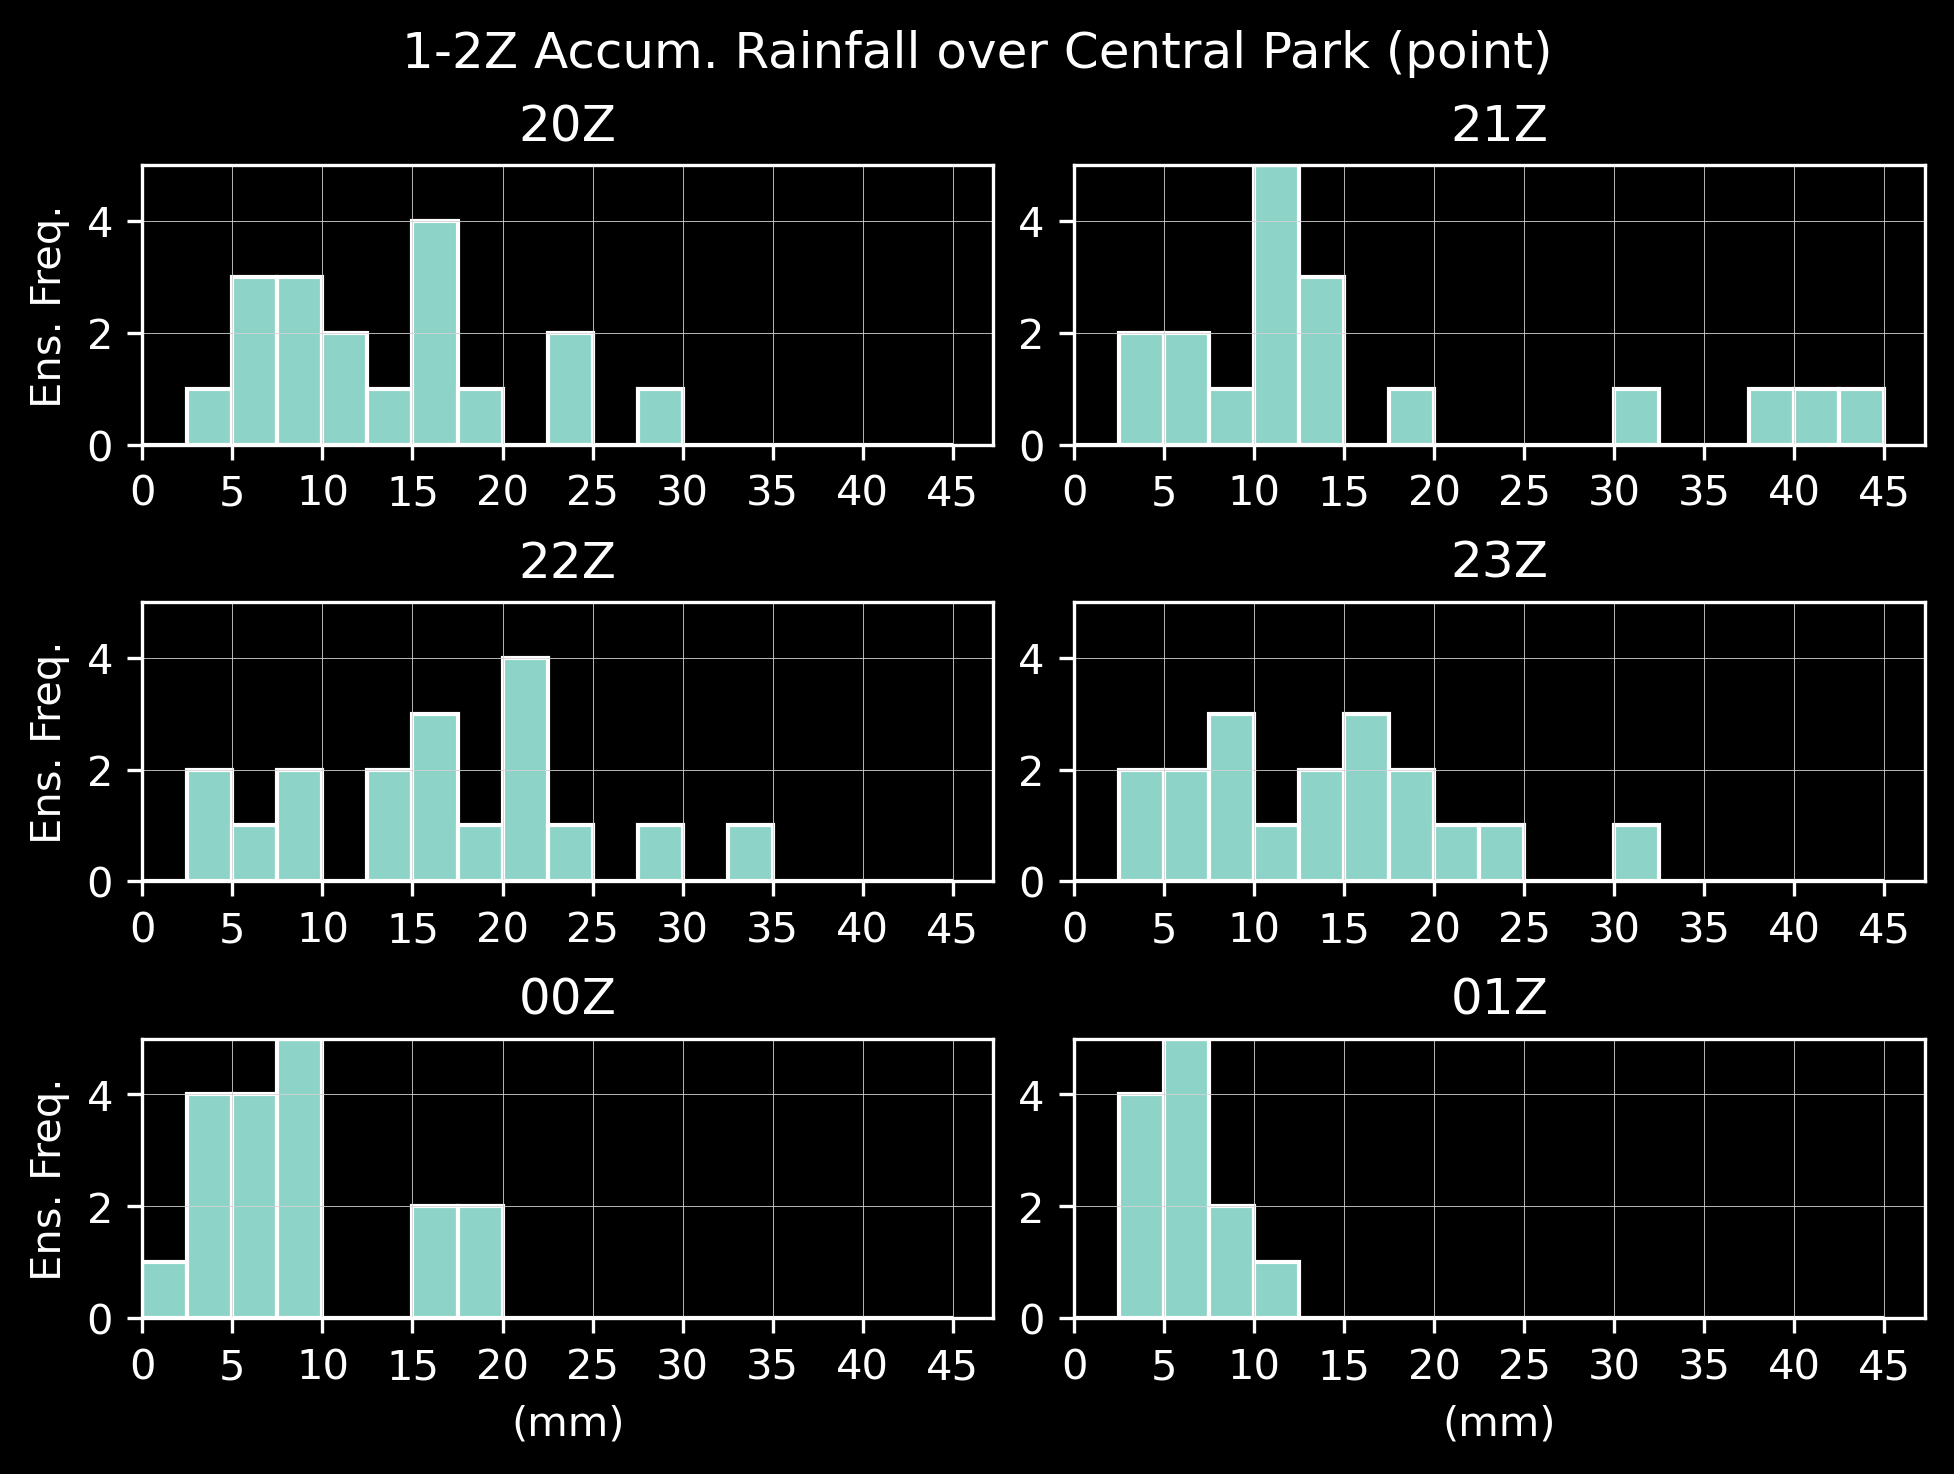

In [25]:
data_to_plot = [rainy_hour_20Z,rainy_hour_21Z,rainy_hour_22Z,
                rainy_hour_23Z,rainy_hour_00Z,rainy_hour_01Z]
titles = ["20Z","21Z","22Z","23Z","00Z","01Z"]
bin_edges = np.arange(0,45.1,2.5)

plt.style.use("dark_background")

fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(data_to_plot[i],ax=ax,edgecolor='white',bins=bin_edges)
    ax.xaxis.set_tick_params(which='both',labelbottom=True)
    ax.set_xticks(np.arange(0,46,5))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")
# xr.plot.hist(rainy_hour_20Z,ax=axes[0],edgecolor='white',bins=bin_edges)
# axes[0].xaxis.set_tick_params(which='both',labelbottom=True)

# xr.plot.hist(rainy_hour_22Z,ax=axes[1],edgecolor='white',bins=bin_edges)

# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("(mm)")
axes[2,0].set_xlabel("(mm)")

plt.ylim(0,5)
plt.xlim(0,)

plt.suptitle("1-2Z Accum. Rainfall over Central Park (point)")
plt.show()

## Take average of 3x3 or 5x5 grid box area around Central Park

In [22]:
# Grab the points either one or two away from our central park point

# I'm tired of making new variables so we are just gonna use a list
rainnc = [r.RAINNC for r in [rainnc_20Z,rainnc_21Z,rainnc_22Z,rainnc_23Z,
rainnc_00Z,rainnc_01Z]]

# There's a lot going on next, but we are basically slicing the data to include the
# points on either side of our central point.
rainnc_3x3 = [r.isel(south_north=slice(int(nyc_inds["south_north"]-1),
                                      int(nyc_inds["south_north"]+2))).isel(
                                          west_east=slice(int(nyc_inds["west_east"]-1),
                                                          int(nyc_inds["west_east"]+2))
                                      ) for r in rainnc]

rainnc_5x5 = [r.isel(south_north=slice(int(nyc_inds["south_north"]-2),
                                      int(nyc_inds["south_north"]+3))).isel(
                                          west_east=slice(int(nyc_inds["west_east"]-2),
                                                          int(nyc_inds["west_east"]+3))
                                      ) for r in rainnc]

# now take the area average and feed into the 1 hr accum function
rainy_hours_3x3 = [get_1Z_to_2Z(
    r.mean(dim=["south_north","west_east"])) for r in rainnc_3x3]

rainy_hours_5x5 = [get_1Z_to_2Z(
    r.mean(dim=["south_north","west_east"])) for r in rainnc_5x5]

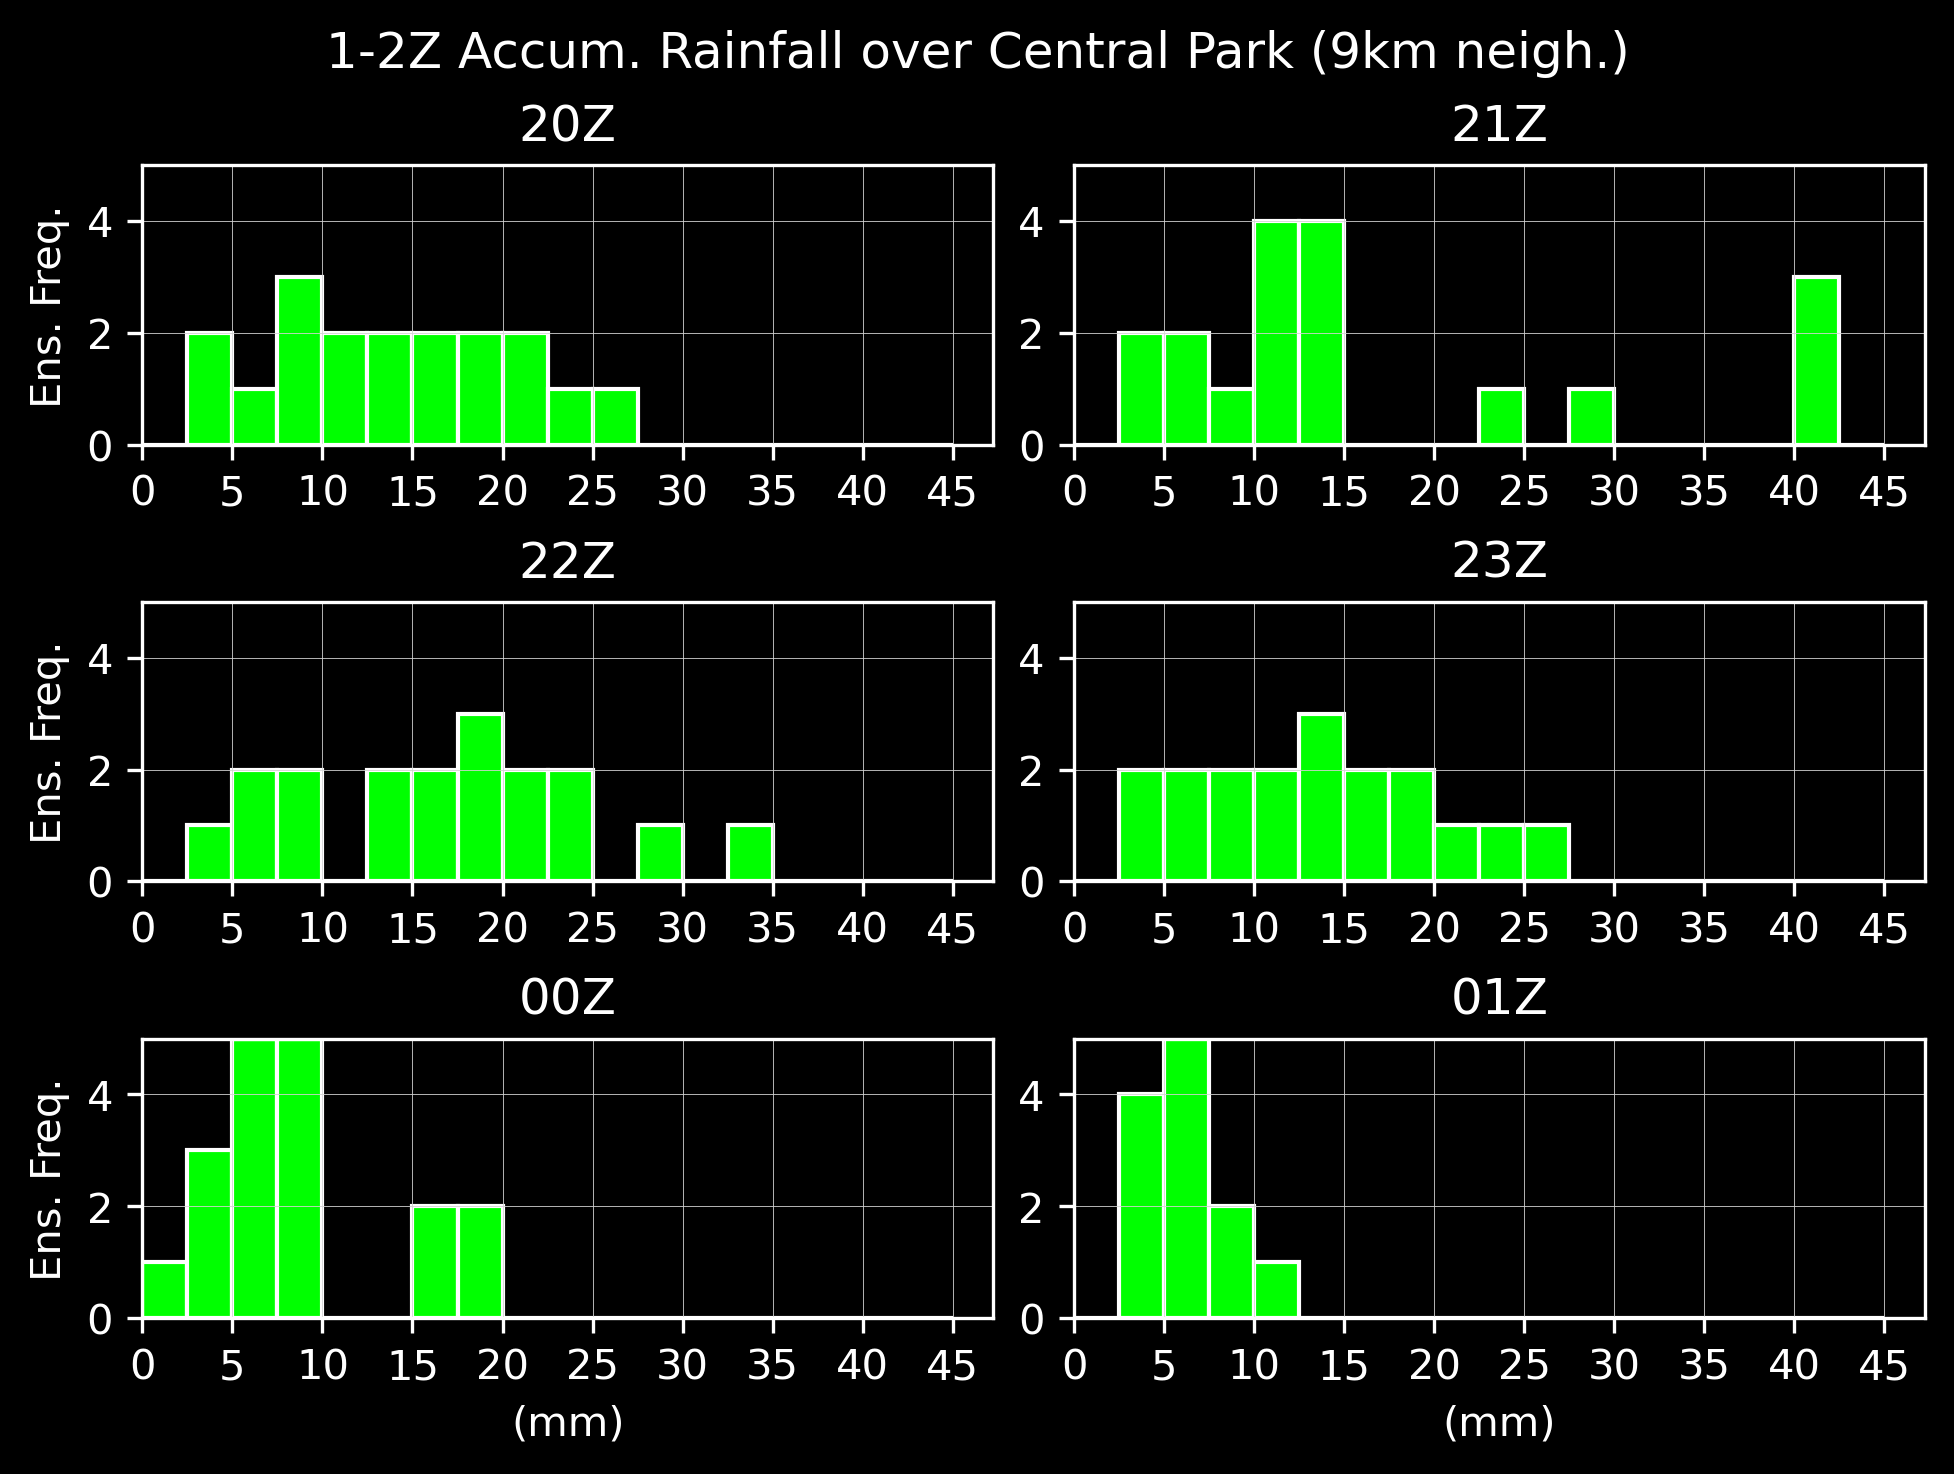

In [26]:
fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(rainy_hours_3x3[i],ax=ax,edgecolor='white',bins=bin_edges,
                color="lime")
    ax.xaxis.set_tick_params(which='both',labelbottom=True)
    ax.set_xticks(np.arange(0,46,5))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")

# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("(mm)")
axes[2,0].set_xlabel("(mm)")

plt.ylim(0,5)
plt.xlim(0,)

plt.suptitle("1-2Z Accum. Rainfall over Central Park (9km neigh.)")
plt.show()

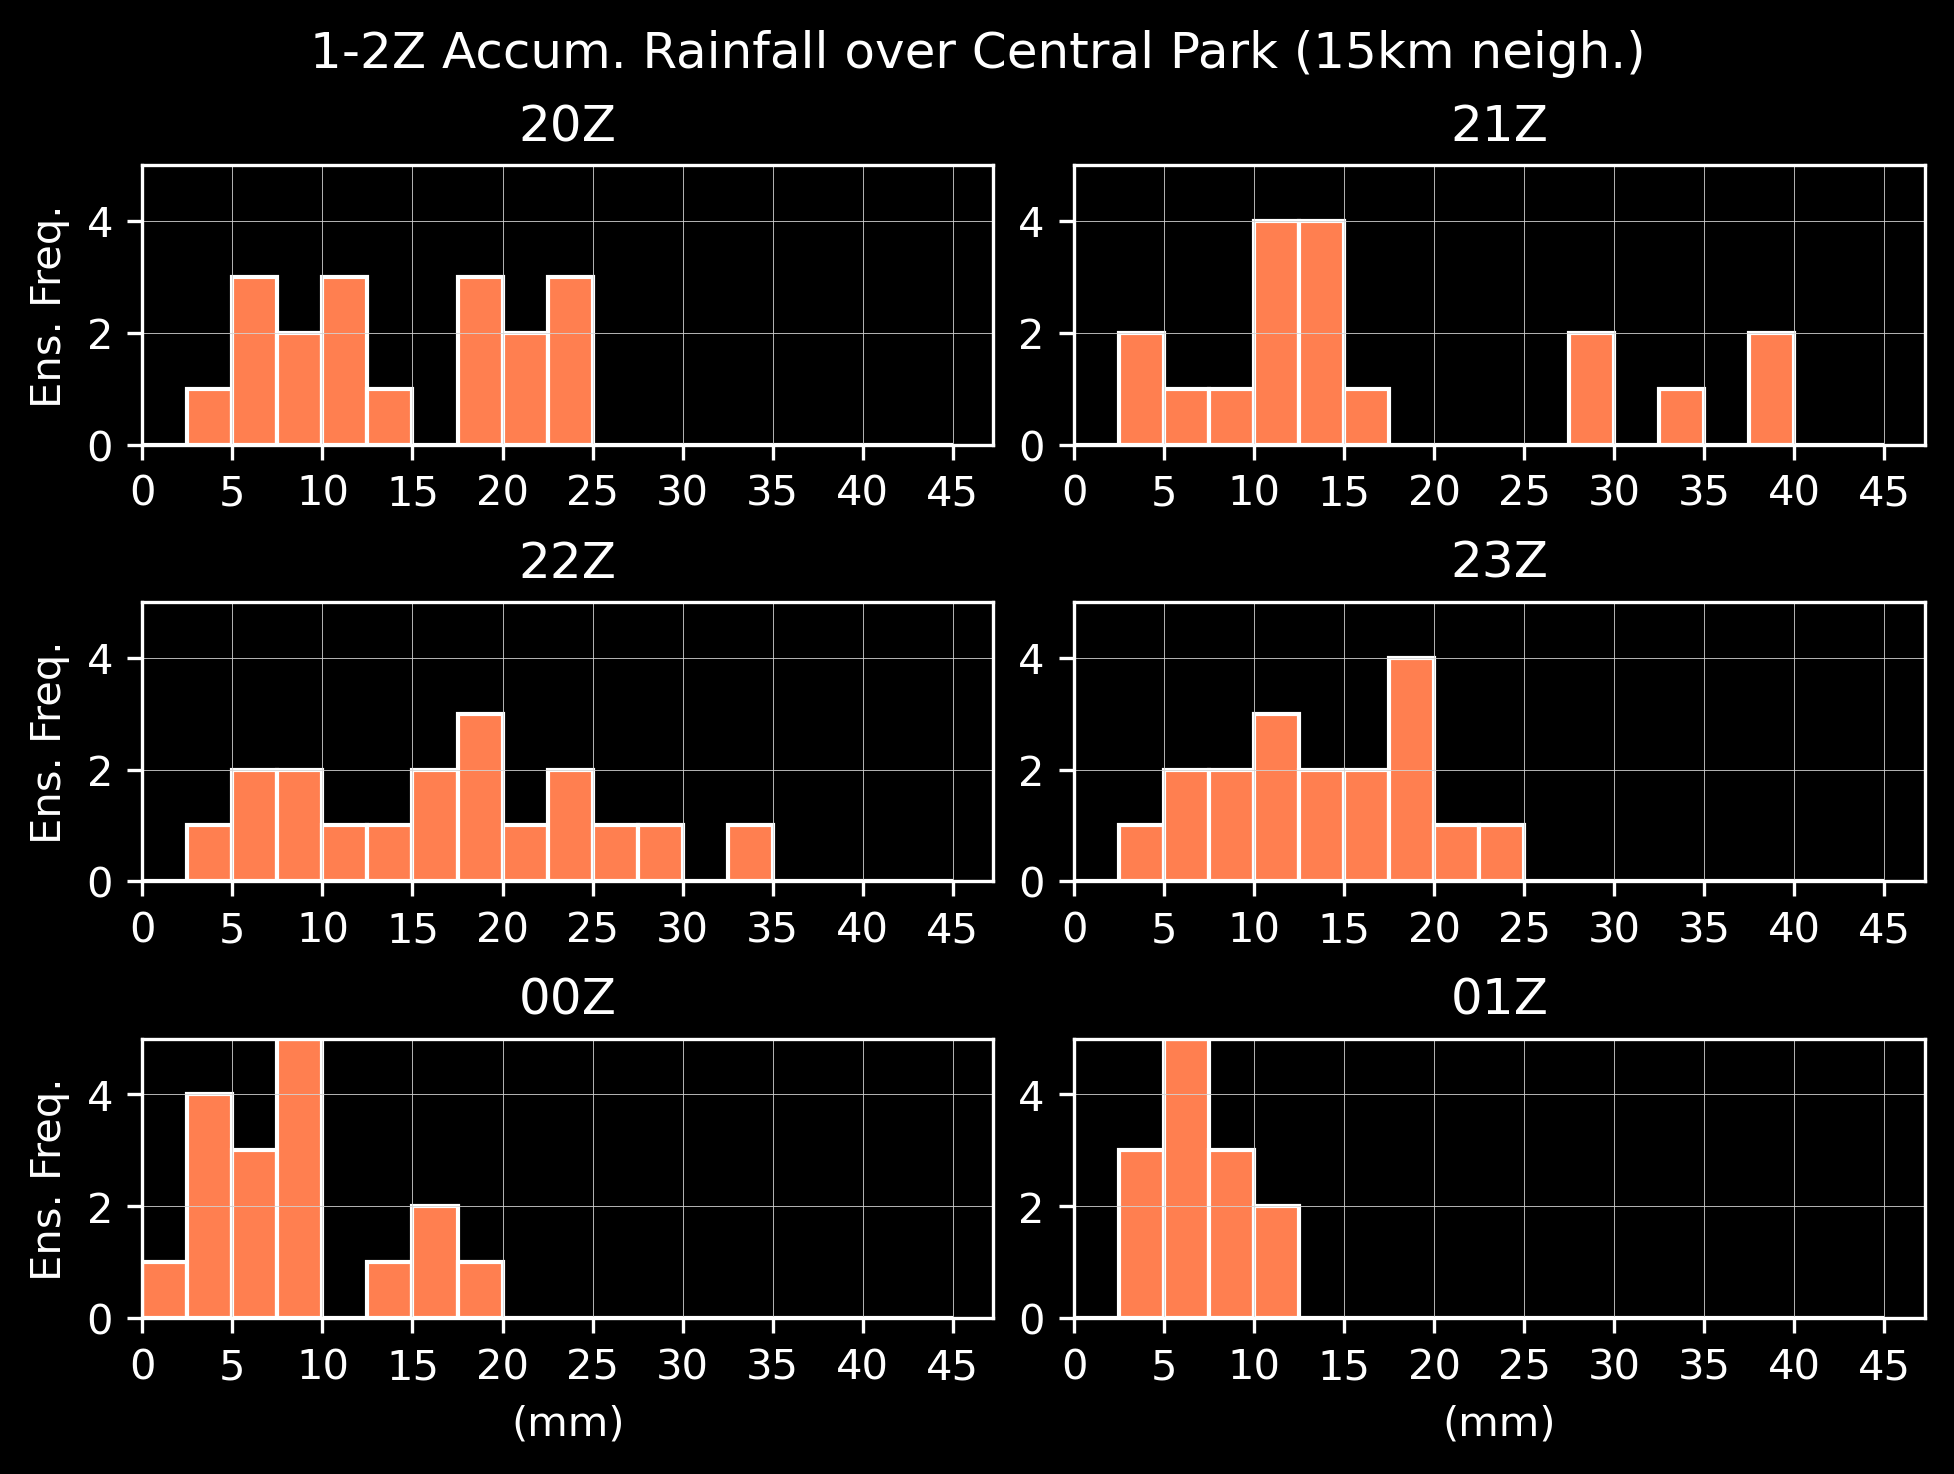

In [28]:
fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(rainy_hours_5x5[i],ax=ax,edgecolor='white',bins=bin_edges,
                color="coral")
    ax.xaxis.set_tick_params(which='both',labelbottom=True)
    ax.set_xticks(np.arange(0,46,5))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")

# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("(mm)")
axes[2,0].set_xlabel("(mm)")

plt.ylim(0,5)
plt.xlim(0,)

plt.suptitle("1-2Z Accum. Rainfall over Central Park (15km neigh.)")
plt.show()

## Find maximum precip in box around Central Park

In [51]:
max_precip = [get_1Z_to_2Z(r).isel(south_north=slice(sn_ind-17,sn_ind+17),
                              west_east=slice(we_ind-17,we_ind+17)).max(
                                  dim=["south_north","west_east"]
                              ).load() for r in [rainnc_20Z,rainnc_21Z,rainnc_22Z,
                                          rainnc_23Z,rainnc_00Z,rainnc_01Z]]

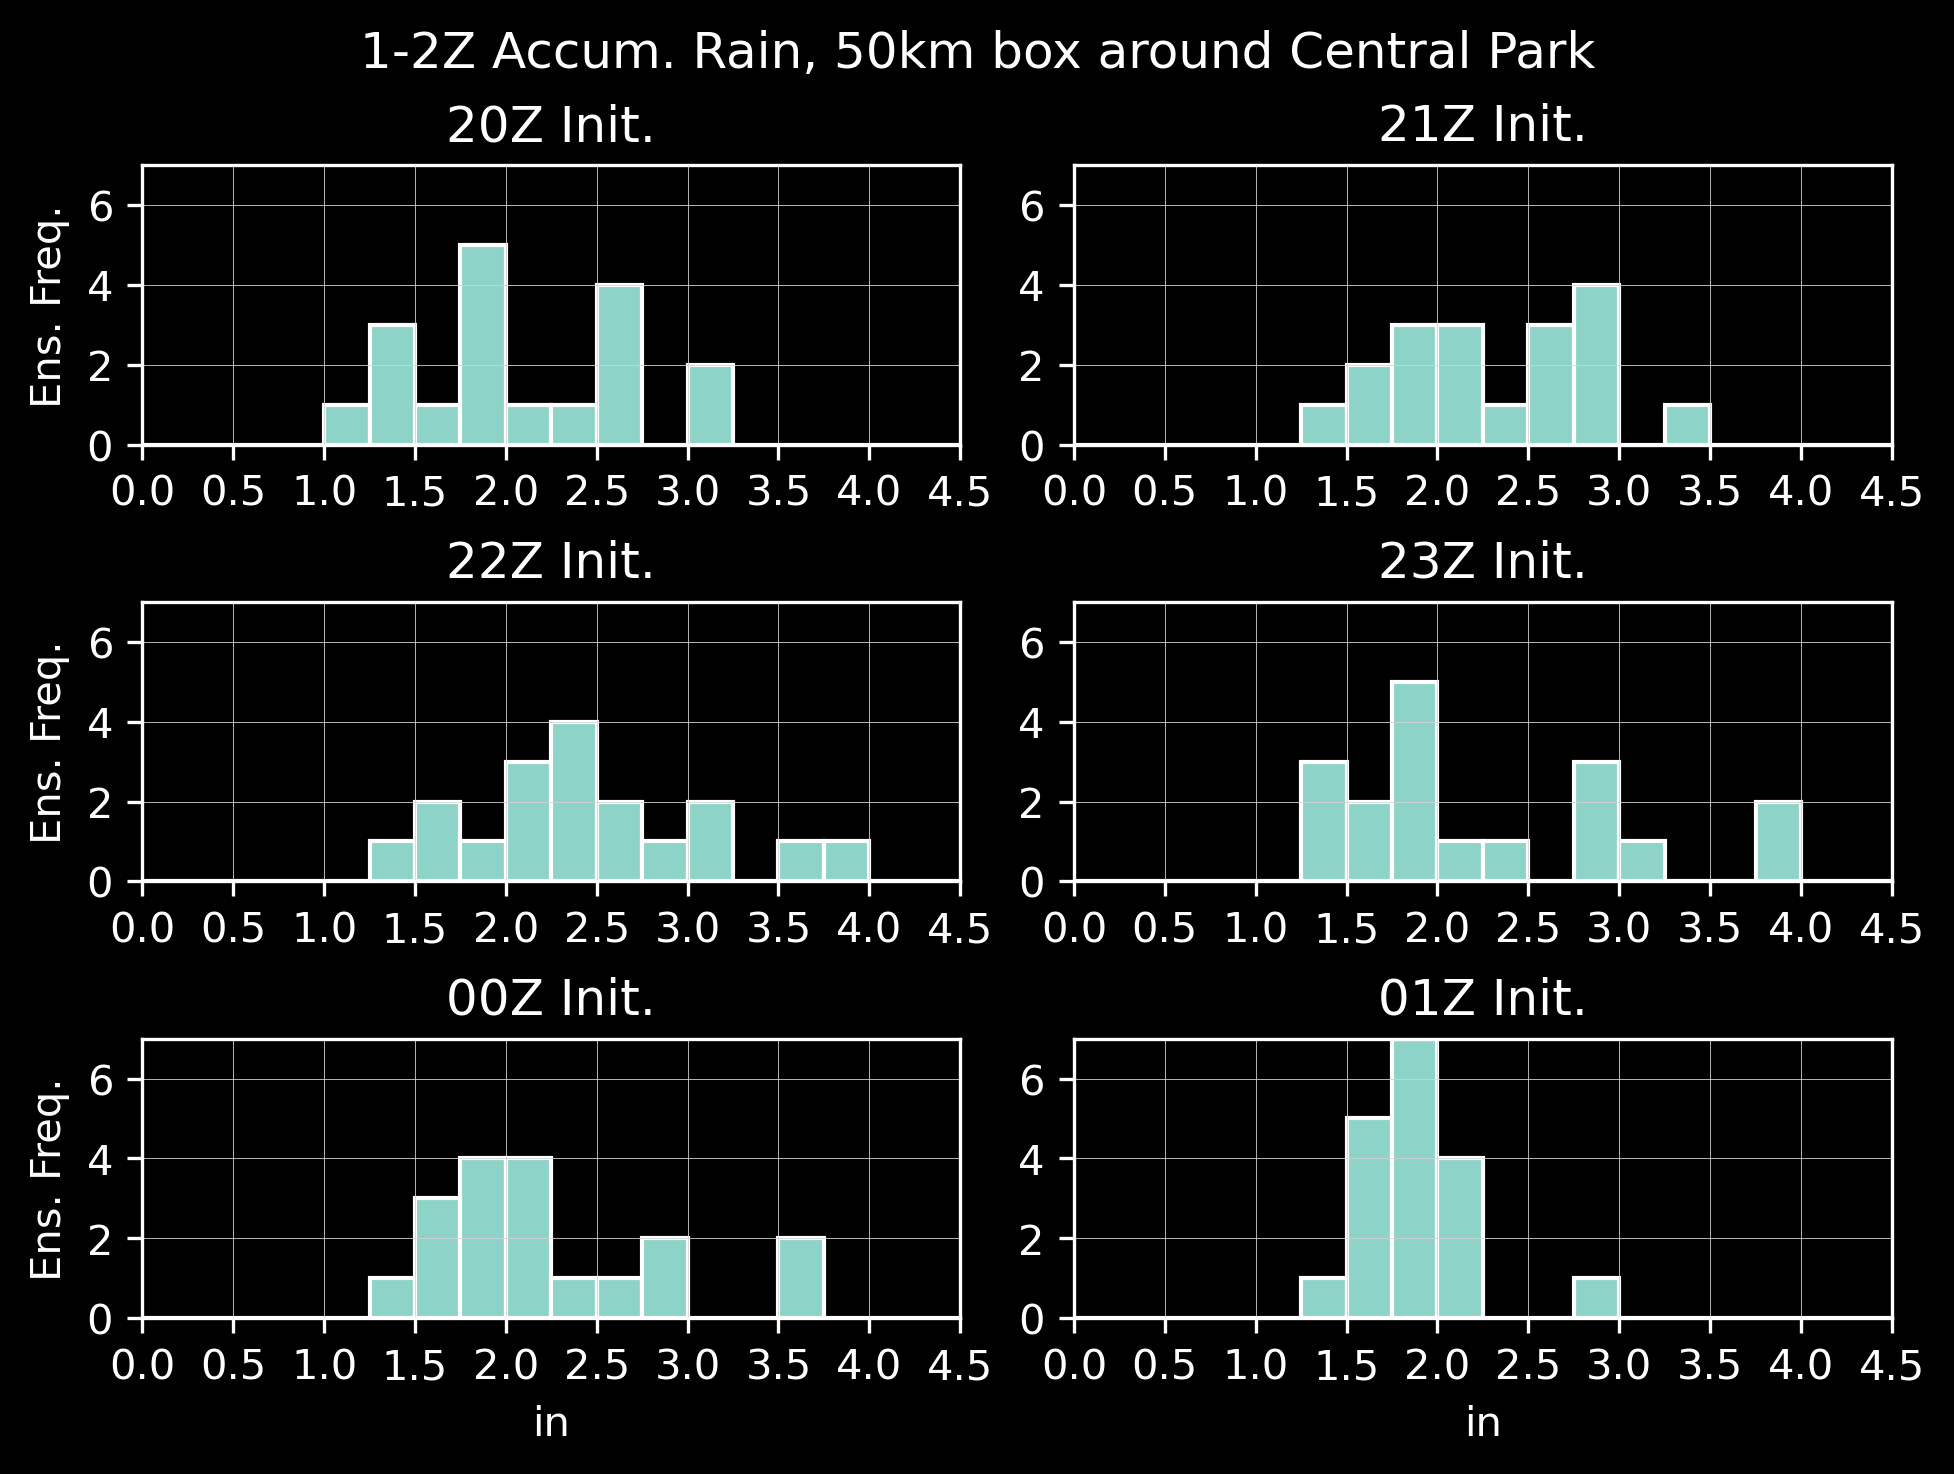

In [53]:
data_to_plot = max_precip
titles = ["20Z Init.","21Z Init.","22Z Init.","23Z Init.","00Z Init.","01Z Init."]
bin_edges = np.arange(0,4.56,0.25)

plt.style.use("dark_background")

fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(data_to_plot[i].RAINNC/25.4,ax=ax,edgecolor='white',bins=bin_edges)
    ax.xaxis.set_tick_params(which='both',labelbottom=True)
    ax.set_xticks(np.arange(0,4.6,0.5))
    ax.set_yticks(np.arange(0,8,2))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")
# xr.plot.hist(rainy_hour_20Z,ax=axes[0],edgecolor='white',bins=bin_edges)
# axes[0].xaxis.set_tick_params(which='both',labelbottom=True)

# xr.plot.hist(rainy_hour_22Z,ax=axes[1],edgecolor='white',bins=bin_edges)

# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("in")
axes[2,0].set_xlabel("in")

plt.ylim(0,7)
plt.xlim(0,4.5)

plt.suptitle("1-2Z Accum. Rain, 50km box around Central Park")
plt.show()

In [55]:
max_precip = [get_1Z_to_2Z(r).isel(south_north=slice(sn_ind-34,sn_ind+34),
                              west_east=slice(we_ind-34,we_ind+34)).max(
                                  dim=["south_north","west_east"]
                              ).load() for r in [rainnc_20Z,rainnc_21Z,rainnc_22Z,
                                          rainnc_23Z,rainnc_00Z,rainnc_01Z]]

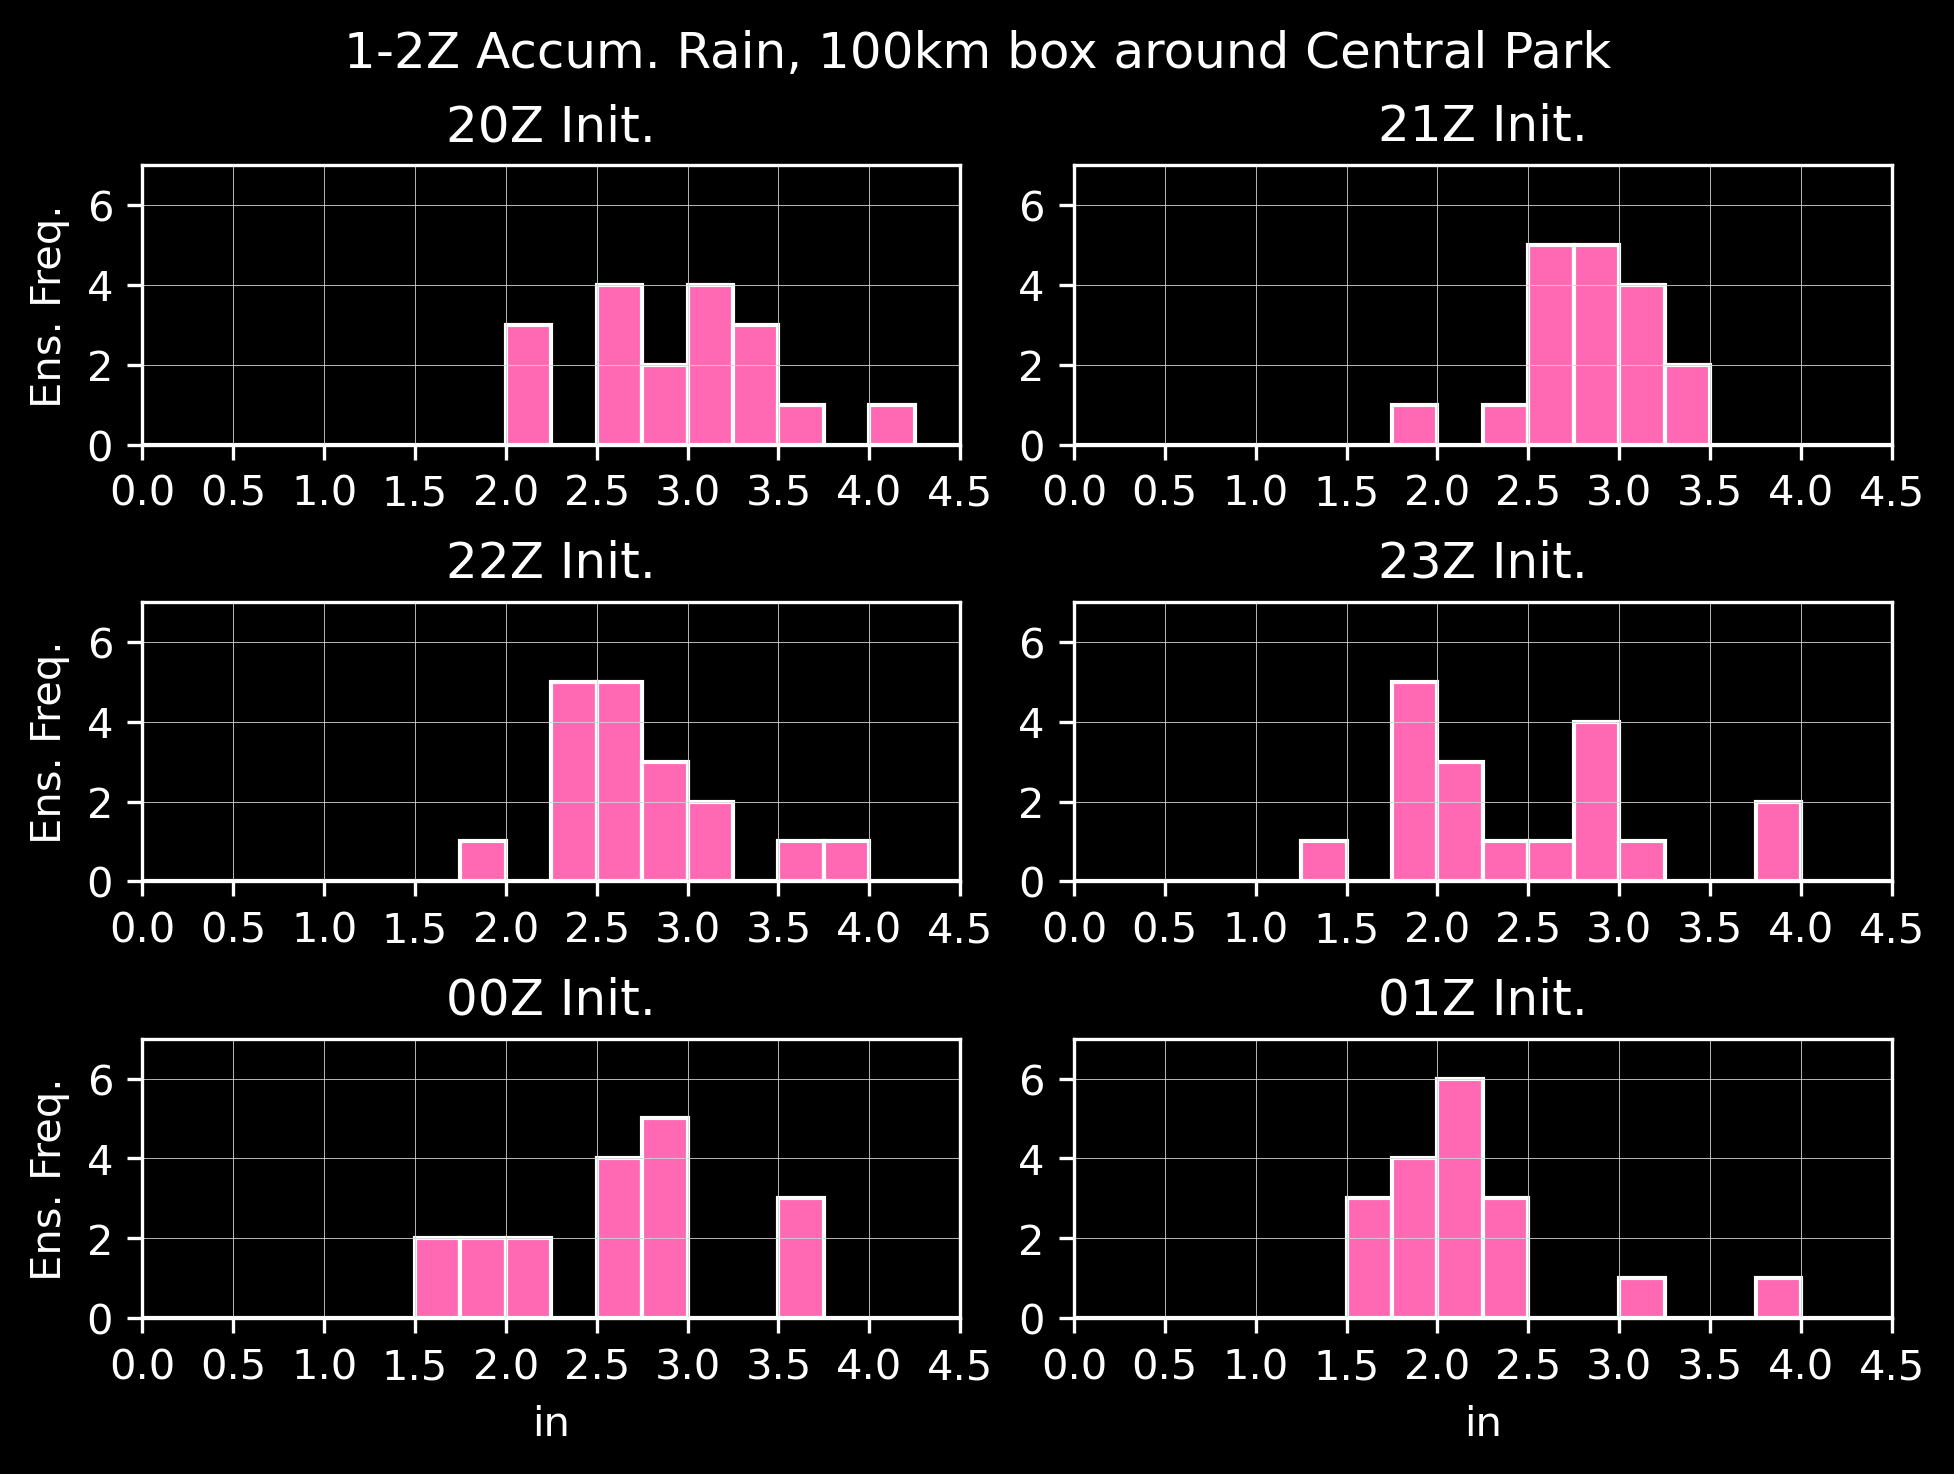

In [56]:
data_to_plot = max_precip
titles = ["20Z Init.","21Z Init.","22Z Init.","23Z Init.","00Z Init.","01Z Init."]
bin_edges = np.arange(0,4.56,0.25)

plt.style.use("dark_background")

fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(data_to_plot[i].RAINNC/25.4,ax=ax,edgecolor='white',bins=bin_edges,
                 color="hotpink")
    ax.xaxis.set_tick_params(which='both',labelbottom=True)
    ax.set_xticks(np.arange(0,4.6,0.5))
    ax.set_yticks(np.arange(0,8,2))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")
# xr.plot.hist(rainy_hour_20Z,ax=axes[0],edgecolor='white',bins=bin_edges)
# axes[0].xaxis.set_tick_params(which='both',labelbottom=True)

# xr.plot.hist(rainy_hour_22Z,ax=axes[1],edgecolor='white',bins=bin_edges)

# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("in")
axes[2,0].set_xlabel("in")

plt.ylim(0,7)
plt.xlim(0,4.5)

plt.suptitle("1-2Z Accum. Rain, 100km box around Central Park")
plt.show()

## Density Map of Max Precip

In [4]:
# Put all the cumulative rain in a list
rainnc = [rainnc_20Z, rainnc_21Z, rainnc_22Z, rainnc_23Z, rainnc_00Z, rainnc_01Z]

# Calculate 5-minute rainfall accumulations (non-cumulative)
rainnc_5min = [r.diff(dim="Time",label="lower") for r in rainnc]

# Make it hourly
rainnc_hourly = [r.groupby(r.XTIME.dt.hour).sum() for r in rainnc_5min]

In [5]:
# Contruct data to plot

# Change this is you want to pick a different hour to plot
# None = plot all hours
hour = 1

lat = rainnc_20Z.XLAT.isel(Time=0)
lon = rainnc_20Z.XLONG.isel(Time=0)

# get central latitude and longitude for projections
central_latitude = 40.650017
central_longitude = -75.42999

# Get coordinates of max precip values
max_coords = [r.RAINNC.sel(hour=slice(hour,hour)).load().argmax(
    dim=["south_north","west_east"])
               for r in rainnc_hourly]
max_values = [np.array(r.RAINNC.sel(hour=slice(hour,hour)).load().max(
    dim=["south_north","west_east"])).ravel()/25.4
              for r in rainnc_hourly]

# Transform coordinates into lat/lon
max_lats = [np.array(lat.isel(west_east=m["west_east"],
                   south_north=m["south_north"])).ravel() 
                   for m in max_coords]
max_lons = [np.array(lon.isel(west_east=m["west_east"],
                   south_north=m["south_north"])).ravel() 
                   for m in max_coords]

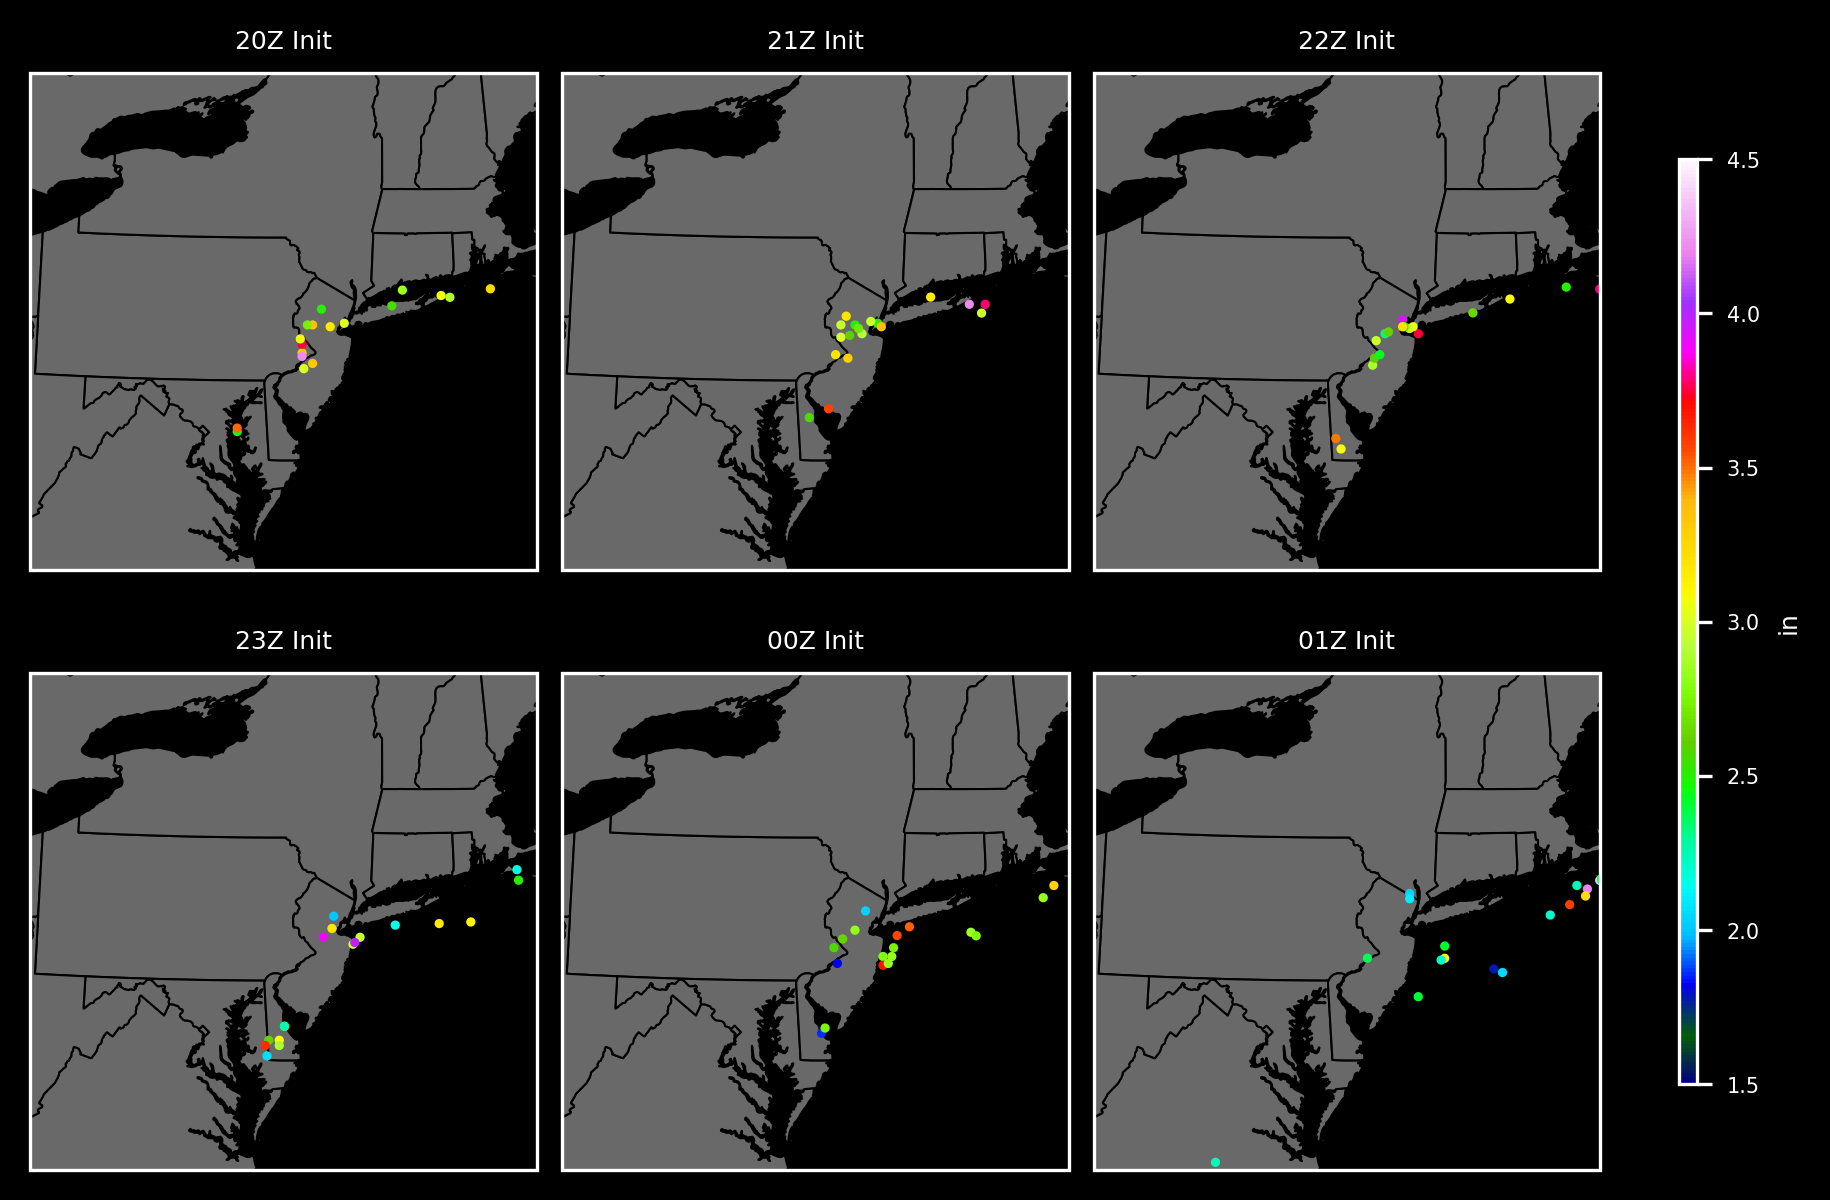

In [6]:
plt.style.use("dark_background")

linewidth=0.5
region=[-80.4,-70.4,36.6,44.5]
titles = ["20Z Init","21Z Init","22Z Init","23Z Init","00Z Init","01Z Init"]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,4))

for i,ax in enumerate(axes.flatten()):
    p = ax.scatter(max_lons[i],max_lats[i],transform=ccrs.PlateCarree(),
                                s=1.5,zorder=2,c=max_values[i],
                                vmin=1.5,vmax=4.5,cmap="gist_ncar")
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth,facecolor="dimgray",
                        edgecolor="black")
    p.axes.set_extent(region,crs=ccrs.PlateCarree())
    ax.set_title(titles[i],fontsize=6)
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=50)
cbar.ax.tick_params(labelsize=5)
cbar.set_label("in",fontsize=6)
plt.show()

In [26]:
# Find a few ensemble members with very different precip maxima locations
# Let's try with 22Z

eastest = rainnc_hourly[2].RAINNC.isel(ens=max_lons[2].argmax()).sel(hour=1)
westest = rainnc_hourly[2].RAINNC.isel(ens=max_lons[2].argmin()).sel(hour=1)
# For a point in the center, calculate the median
med_idx = np.argsort(max_lons[2])[len(max_lons[2])//2]
centerest = rainnc_hourly[2].RAINNC.isel(ens=med_idx).sel(hour=1)

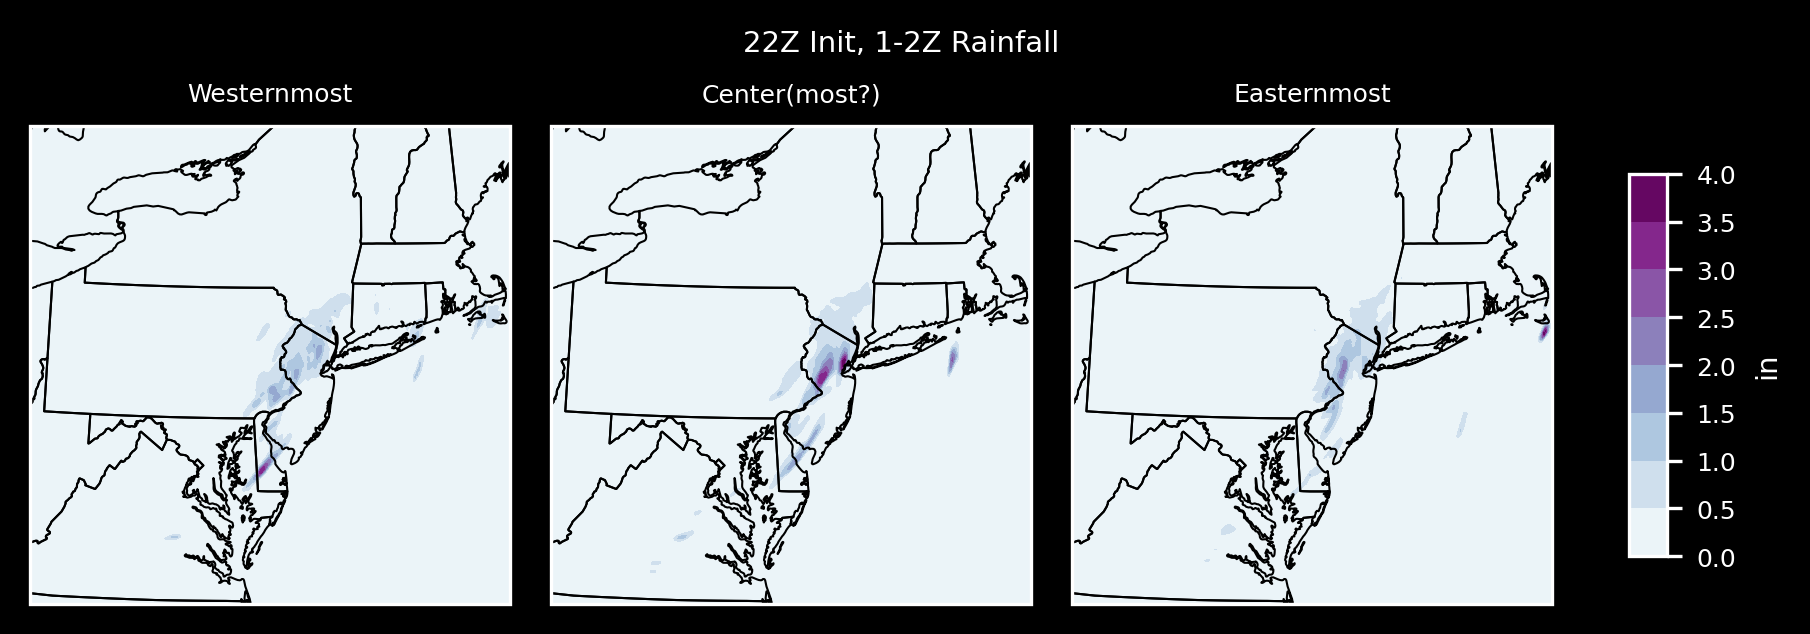

In [51]:
plt.style.use("dark_background")

linewidth=0.5
region=[-80.4,-70.4,36.6,44.5]
data_to_plot = [westest, centerest, eastest]
titles = ["Westernmost","Center(most?)","Easternmost"]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude,
                             standard_parallels=(30,60))

fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,2))

for i,ax in enumerate(axes):
    p = ax.contourf(lon,lat,data_to_plot[i]/25.4,
                      transform=ccrs.PlateCarree(),
                      cmap="BuPu",levels=np.arange(0,4.1,0.5))
    # p.axes.set_extent(region,crs=ccrs.PlateCarree())
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i],fontsize=6)

plt.suptitle("22Z Init, 1-2Z Rainfall",fontsize=7)
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=10)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("in",fontsize=7)
plt.show()

In [52]:
# Repeat for 00Z

eastest = rainnc_hourly[4].RAINNC.isel(ens=max_lons[4].argmax()).sel(hour=1)
westest = rainnc_hourly[4].RAINNC.isel(ens=max_lons[4].argmin()).sel(hour=1)
# For a point in the center, calculate the median
med_idx = np.argsort(max_lons[4])[len(max_lons[4])//2]
centerest = rainnc_hourly[4].RAINNC.isel(ens=med_idx).sel(hour=1) 


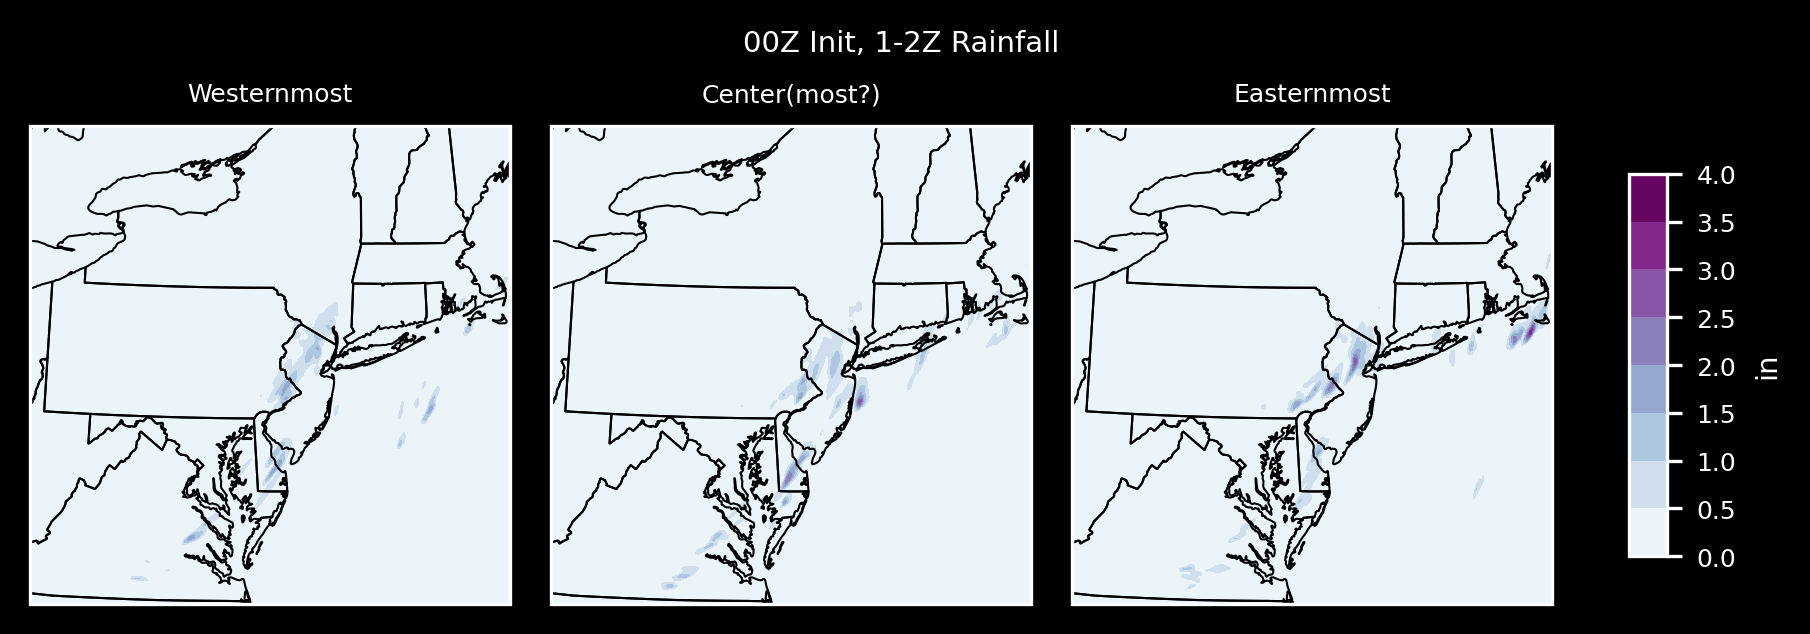

In [53]:
plt.style.use("dark_background")

linewidth=0.5
region=[-80.4,-70.4,36.6,44.5]
data_to_plot = [westest, centerest, eastest]
titles = ["Westernmost","Center(most?)","Easternmost"]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude,
                             standard_parallels=(30,60))

fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,2))

for i,ax in enumerate(axes):
    p = ax.contourf(lon,lat,data_to_plot[i]/25.4,
                      transform=ccrs.PlateCarree(),
                      cmap="BuPu",levels=np.arange(0,4.1,0.5))
    # p.axes.set_extent(region,crs=ccrs.PlateCarree())
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i],fontsize=6)

plt.suptitle("00Z Init, 1-2Z Rainfall",fontsize=7)
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=10)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("in",fontsize=7)
plt.show()